# Saleh-Valenzuela for UPA



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# === PARAMETERS ===
N_samples = 100000
Nx, Ny = 16, 16
N = Nx * Ny
M = 128  # Measurements
L = 3    # Paths
p = 4    # Number of 1's per column in switch matrix
snr_db = np.arange(0, 21, 5)

np.random.seed(0)
torch.manual_seed(0)

# === 2D-DFT Matrix U ===
Fx = np.fft.fft(np.eye(Nx), norm='ortho')
Fy = np.fft.fft(np.eye(Ny), norm='ortho')
U = np.kron(Fy, Fx)

# === Saleh-Valenzuela Channel Model ===
def SV_UPA_spatial(Nx, Ny, L):
    h = np.zeros((Nx, Ny), dtype=complex)
    for _ in range(L):
        α = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
        θ = np.random.uniform(-np.pi/2, np.pi/2)
        ϕ = np.random.uniform(-np.pi/2, np.pi/2)
        n1 = np.arange(Nx)[:, None]
        n2 = np.arange(Ny)[None, :]
        ax = np.exp(-1j * np.pi * n1 * np.sin(θ) * np.sin(ϕ))
        ay = np.exp(-1j * np.pi * np.cos(ϕ) * n2)
        a2D = (ax * ay) / np.sqrt(Nx * Ny)
        h += α * a2D
    return np.sqrt(Nx * Ny / L) * h

# === Switch-based Selection Matrix (binary 0/1) ===
def create_switch_matrix(M, N, p):
    A = np.zeros((M, N))
    for j in range(N):
        indices = np.random.choice(M, p, replace=False)
        A[indices, j] = 1
    return A

# Create fixed switch matrix
A_switch = create_switch_matrix(M, N, p)

# === Generate channels ===
h_spatial = np.zeros((N_samples, N), dtype=complex)
for i in range(N_samples):
    h_spatial[i] = SV_UPA_spatial(Nx, Ny, L).ravel()

# === Get CLEAN BEAMSPACE CHANNEL ===
h_beamspace = (U @ h_spatial.T).T  # N_samples x N

# === Get MEASUREMENTS ===
y_clean = (A_switch @ h_beamspace.T).T  # N_samples x M

# === Split real/imag/amplitude/phase ===
def preprocess_input(y):
    y_real = np.real(y)
    y_imag = np.imag(y)
    y_amp = np.abs(y)
    y_phase = np.angle(y)
    return np.stack([y_real, y_imag, y_amp, y_phase], axis=1)  # (batch, 4, M)

# === NORMALIZE CHANNELS ===
norm_factor = np.sqrt(np.mean(np.abs(h_beamspace)**2))
h_beamspace_normalized = h_beamspace / norm_factor

# === Measurements ===
y_clean = (A_switch @ h_beamspace_normalized.T).T  # (N_samples, M)

# === Inputs and Targets ===
X = preprocess_input(y_clean)
y_target = np.stack([np.real(h_beamspace_normalized), np.imag(h_beamspace_normalized)], axis=1)

# === Tensor Datasets
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)



# Sizes
n_total = len(X_tensor)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val  # rest goes to test

# Random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    TensorDataset(X_tensor, y_tensor),
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # for reproducibility
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [2]:

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)
        self.norm2 = nn.GroupNorm(8, channels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.norm1(x)
        out = F.silu(out)
        out = self.conv1(out)
        out = self.dropout(out)
        out = self.norm2(out)
        out = F.silu(out)
        out = self.conv2(out)
        return x + out

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.scale = (channels // 8) ** 0.5  # smaller head size

    def forward(self, x):
        B, C, L = x.shape
        qkv = self.qkv(x)  # (B, 3C, L)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        attn = torch.softmax(torch.bmm(q.transpose(1, 2), k) / self.scale, dim=-1)
        out = torch.bmm(attn, v.transpose(1, 2)).transpose(1, 2)
        return x + out

class Downsample(nn.Module):
    def __init__(self, in_c, out_c):
        super(Downsample, self).__init__()
        self.conv = nn.Conv1d(in_c, out_c, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, in_c, out_c):
        super(Upsample, self).__init__()
        self.conv = nn.ConvTranspose1d(in_c, out_c, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, M, N):
        super(AttentionUNet, self).__init__()
        self.fc = nn.Linear(M * 4, N)

        self.enc1 = nn.Sequential(
            Downsample(1, 32),
            ResidualBlock(32),
            AttentionBlock(32)
        )
        self.enc2 = nn.Sequential(
            Downsample(32, 64),
            ResidualBlock(64),
            AttentionBlock(64)
        )
        self.enc3 = nn.Sequential(
            Downsample(64, 128),
            ResidualBlock(128),
            AttentionBlock(128)
        )

        self.dec1 = nn.Sequential(
            Upsample(128, 64),
            ResidualBlock(64),
            AttentionBlock(64)
        )
        self.dec2 = nn.Sequential(
            Upsample(128, 32),
            ResidualBlock(32),
            AttentionBlock(32)
        )
        self.dec3 = nn.Sequential(
            Upsample(64, 16),
            ResidualBlock(16),
            AttentionBlock(16)
        )

        self.out = nn.Conv1d(16, 2, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.fc(x)  # (batch, N)
        x = x.unsqueeze(1)  # (batch, 1, N)

        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        d1 = self.dec1(e3)
        d1 = torch.cat((d1, e2), dim=1)

        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e1), dim=1)

        d3 = self.dec3(d2)

        out = self.out(d3)
        return out


In [3]:
# === LOSS AND OPTIMIZER ===
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(M=M, N=N).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# === TRAIN FUNCTION ===
def train(model, train_loader, val_loader, n_epochs=100):
    best_val_loss = np.inf
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_attention_unet.pth')

    print('Training Complete.')
    return history

# === TEST FUNCTION ===
def test(model, test_loader):
    model.eval()
    nmse_total = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            mse = torch.mean(torch.abs(y_pred - y_batch) ** 2, dim=[1,2])
            power = torch.mean(torch.abs(y_batch) ** 2, dim=[1,2])
            nmse_batch = mse / power
            nmse_total += torch.sum(nmse_batch).item()

    avg_nmse = nmse_total / len(test_loader.dataset)
    avg_nmse_db = 10 * np.log10(avg_nmse)
    return avg_nmse, avg_nmse_db



In [4]:
snr_db =[0,5,10,15,20]

def add_noise(y_clean, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(y_clean)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

nmse_list_db = []

for snr in snr_db:  # snr_db = [0,5,10,15,20]
    print(f"\n=== Processing SNR = {snr} dB ===")

    # Add noise to the measurements
    y_noisy = add_noise(y_clean, snr)

    # Prepare new noisy dataset
    X_noisy = preprocess_input(y_noisy)  # (batch, 4, M)

    X_tensor_noisy = torch.tensor(X_noisy, dtype=torch.float32)
    y_tensor_target = torch.tensor(y_target, dtype=torch.float32)  # same target (no noise in label)

    # New split
    dataset_noisy = TensorDataset(X_tensor_noisy, y_tensor_target)
    n_total = len(dataset_noisy)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset_noisy, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # New model instance for each SNR
    model = AttentionUNet(M=M, N=N).to(device)

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # Train
    train(model, train_loader, val_loader, n_epochs=20)

    # Test
    model.load_state_dict(torch.load('best_attention_unet.pth'))
    nmse, nmse_db_value = test(model, test_loader)
    nmse_list_db.append(nmse_db_value)

    print(f"SNR {snr} dB: Test NMSE = {nmse:.6f} | {nmse_db_value:.2f} dB")



=== Processing SNR = 0 dB ===
Epoch [1/20] | Train Loss: 0.403606 | Val Loss: 0.322491
Epoch [2/20] | Train Loss: 0.261104 | Val Loss: 0.210391
Epoch [3/20] | Train Loss: 0.188226 | Val Loss: 0.169817
Epoch [4/20] | Train Loss: 0.156725 | Val Loss: 0.147764
Epoch [5/20] | Train Loss: 0.137760 | Val Loss: 0.133498
Epoch [6/20] | Train Loss: 0.124680 | Val Loss: 0.124566
Epoch [7/20] | Train Loss: 0.115785 | Val Loss: 0.117433
Epoch [8/20] | Train Loss: 0.109308 | Val Loss: 0.111653
Epoch [9/20] | Train Loss: 0.104587 | Val Loss: 0.108836
Epoch [10/20] | Train Loss: 0.100702 | Val Loss: 0.106000
Epoch [11/20] | Train Loss: 0.097480 | Val Loss: 0.103055
Epoch [12/20] | Train Loss: 0.094754 | Val Loss: 0.100959
Epoch [13/20] | Train Loss: 0.092491 | Val Loss: 0.098628
Epoch [14/20] | Train Loss: 0.090422 | Val Loss: 0.098196
Epoch [15/20] | Train Loss: 0.088569 | Val Loss: 0.096527
Epoch [16/20] | Train Loss: 0.086959 | Val Loss: 0.095511
Epoch [17/20] | Train Loss: 0.085522 | Val Loss: 0

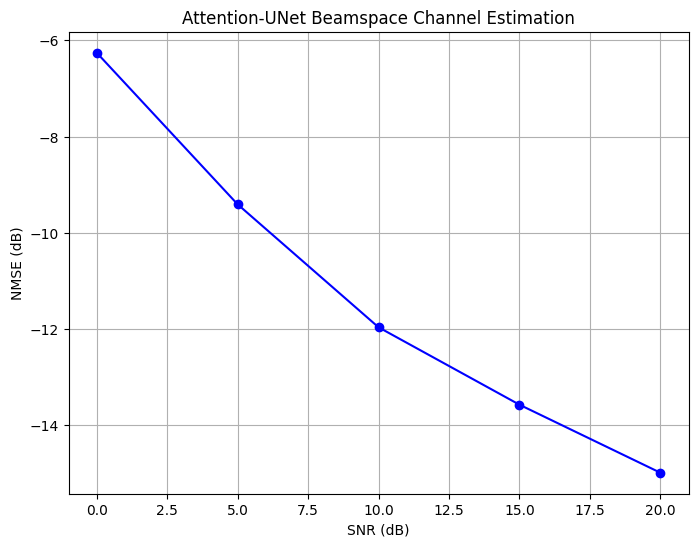

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(snr_db, nmse_list_db, marker='o', linestyle='-', color='b')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.title('Attention-UNet Beamspace Channel Estimation')
plt.grid(True)
plt.show()


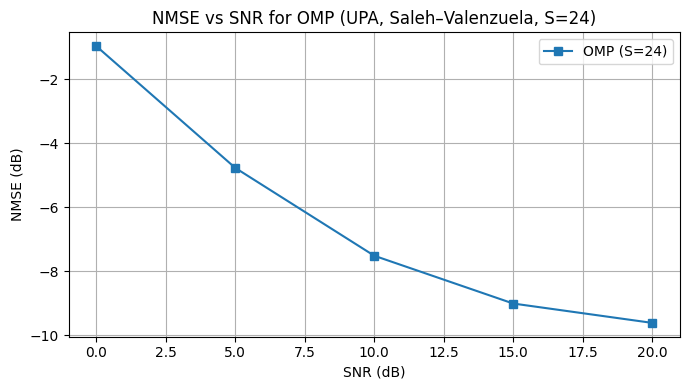

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) PARAMETERS ===
N_samples = 100000
Nx, Ny = 16, 16
N = Nx * Ny
M = 128
L = 3
S = 24
snr_db = np.arange(0, 21, 5)

np.random.seed(0)

# === 2) PHASE-SHIFTER SENSING MATRIX A ∈ {±1/√M} ===
A = np.random.choice([1, -1], size=(M, N)) / np.sqrt(M)

# === 3) UNITARY 2-D DFT “LENS” MATRIX U ===
Fx = np.fft.fft(np.eye(Nx), norm='ortho')
Fy = np.fft.fft(np.eye(Ny), norm='ortho')
U = np.kron(Fy, Fx)

# === 4) SALEH-VALENZUELA UPA CHANNEL GENERATOR ===
def SV_UPA_spatial(Nx, Ny, L):
    h = np.zeros((Nx, Ny), dtype=complex)
    for _ in range(L):
        α = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
        θ = np.random.uniform(-np.pi/2, np.pi/2)
        ϕ = np.random.uniform(-np.pi/2, np.pi/2)
        n1 = np.arange(Nx)[:, None]
        n2 = np.arange(Ny)[None, :]
        ax = np.exp(-1j * np.pi * n1 * np.sin(θ) * np.sin(ϕ))
        ay = np.exp(-1j * np.pi * np.cos(ϕ) * n2)
        a2D = (ax * ay) / np.sqrt(Nx * Ny)
        h += α * a2D
    return np.sqrt(Nx * Ny / L) * h

# === 5) BUILD SPATIAL CHANNELS (NOT BEAMSPACE YET!) ===
h_spatial = np.zeros((N_samples, N), dtype=complex)
for i in range(N_samples):
    h_spatial[i] = SV_UPA_spatial(Nx, Ny, L).ravel()

# === 6) CLEAN MEASUREMENTS ===
y_clean = (A @ (U @ h_spatial.T)).T  # y = A * (U * h_spatial)

# === 7) OMP FUNCTION ===
def omp(y, A, S):
    residual = y.copy()
    support = []
    x_hat = np.zeros(A.shape[1], dtype=complex)
    for _ in range(S):
        corr = A.conj().T @ residual
        idx = np.argmax(np.abs(corr))
        if idx in support:
            break
        support.append(idx)
        A_sub = A[:, support]
        x_sub, *_ = np.linalg.lstsq(A_sub, y, rcond=None)
        residual = y - A_sub @ x_sub
    x_hat[support] = x_sub
    return x_hat

# === 8) SWEEP SNR AND COMPUTE NMSE ===
nmse_db_omp = []
for db in snr_db:
    snr_lin = 10**(db/10)
    σ = np.sqrt(1/(2*snr_lin))
    errors = []
    for i in range(N_samples):
        noise = (np.random.randn(M) + 1j*np.random.randn(M)) * σ
        y_noisy = y_clean[i] + noise
        h_est_spatial = np.linalg.pinv(U) @ omp(y_noisy, A, S)  # recover h_spatial
        h_est_beam = U @ h_est_spatial  # transform to beamspace
        h_true_beam = U @ h_spatial[i]  # true beamspace
        errors.append(np.linalg.norm(h_est_beam - h_true_beam)**2
                      / np.linalg.norm(h_true_beam)**2)
    nmse_db_omp.append(10*np.log10(np.mean(errors)))

# === 9) PLOT ===
plt.figure(figsize=(7,4))
plt.plot(snr_db, nmse_db_omp, 's-', label=f'OMP (S={S})')
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("NMSE vs SNR for OMP (UPA, Saleh–Valenzuela, S=24)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


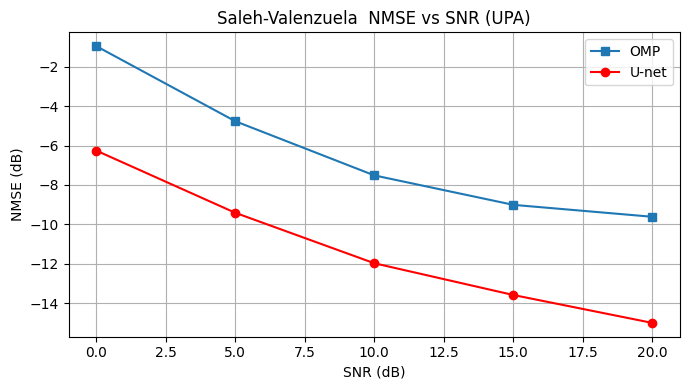

In [17]:
plt.figure(figsize=(7,4))
plt.plot(snr_db, nmse_db_omp, 's-', label=f'OMP')
plt.plot(snr_db, nmse_list_db, marker='o', linestyle='-', color='r',label=f'U-net')
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("Saleh-Valenzuela  NMSE vs SNR (UPA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def add_noise(y_clean, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(y_clean)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

snr_train_range = [0, 5, 10, 15, 20]  # range of SNRs during training

# Generate noisy training measurements
y_noisy_list = []
for i in range(len(y_clean)):
    random_snr = np.random.choice(snr_train_range)
    y_noisy_i = add_noise(y_clean[i:i+1], random_snr)  # add noise sample by sample
    y_noisy_list.append(y_noisy_i)

y_noisy_train = np.concatenate(y_noisy_list, axis=0)  # Shape (N_samples, M)

# Prepare input features
X_train = preprocess_input(y_noisy_train)

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor_target = torch.tensor(y_target, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor_target)
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = AttentionUNet(M=M, N=N).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train(model, train_loader, val_loader, n_epochs=30)
model.load_state_dict(torch.load('best_attention_unet.pth'))

nmse_list_db = []

for snr in snr_db:
    print(f"\n=== Testing at SNR = {snr} dB ===")

    # Add noise to original test set
    y_test_clean = y_clean[test_dataset.indices]  # test samples
    y_test_noisy = add_noise(y_test_clean, snr)
    X_test_noisy = preprocess_input(y_test_noisy)

    X_test_tensor = torch.tensor(X_test_noisy, dtype=torch.float32).to(device)
    y_test_tensor = y_tensor[test_dataset.indices].to(device)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)

        mse = torch.mean(torch.abs(y_pred - y_test_tensor)**2, dim=[1,2])
        power = torch.mean(torch.abs(y_test_tensor)**2, dim=[1,2])
        nmse_batch = mse / power
        nmse = torch.mean(nmse_batch).item()

    nmse_db_value = 10 * np.log10(nmse)
    nmse_list_db.append(nmse_db_value)

    print(f"SNR {snr} dB: NMSE = {nmse:.6f} | {nmse_db_value:.2f} dB")


Epoch [1/30] | Train Loss: 0.244224 | Val Loss: 0.109354
Epoch [2/30] | Train Loss: 0.092780 | Val Loss: 0.076495
Epoch [3/30] | Train Loss: 0.071672 | Val Loss: 0.063313
Epoch [4/30] | Train Loss: 0.062040 | Val Loss: 0.056953
Epoch [5/30] | Train Loss: 0.056044 | Val Loss: 0.053010
Epoch [6/30] | Train Loss: 0.051955 | Val Loss: 0.050115
Epoch [7/30] | Train Loss: 0.048982 | Val Loss: 0.047988
Epoch [8/30] | Train Loss: 0.046666 | Val Loss: 0.045485
Epoch [9/30] | Train Loss: 0.044743 | Val Loss: 0.043711
Epoch [10/30] | Train Loss: 0.043197 | Val Loss: 0.042889
Epoch [11/30] | Train Loss: 0.041858 | Val Loss: 0.042006
Epoch [12/30] | Train Loss: 0.040708 | Val Loss: 0.041972
Epoch [13/30] | Train Loss: 0.039762 | Val Loss: 0.040285
Epoch [14/30] | Train Loss: 0.038874 | Val Loss: 0.039454
Epoch [15/30] | Train Loss: 0.038080 | Val Loss: 0.039315
Epoch [16/30] | Train Loss: 0.037419 | Val Loss: 0.038764
Epoch [17/30] | Train Loss: 0.036787 | Val Loss: 0.038551
Epoch [18/30] | Train L

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.10 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.22 GiB is free. Process 355805 has 12.52 GiB memory in use. Of the allocated memory 10.44 GiB is allocated by PyTorch, and 1.94 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


=== Testing at SNR = 0 dB ===
SNR 0 dB: NMSE = 0.231650 | -6.35 dB

=== Testing at SNR = 5 dB ===
SNR 5 dB: NMSE = 0.095890 | -10.18 dB

=== Testing at SNR = 10 dB ===
SNR 10 dB: NMSE = 0.053430 | -12.72 dB

=== Testing at SNR = 15 dB ===
SNR 15 dB: NMSE = 0.040513 | -13.92 dB

=== Testing at SNR = 20 dB ===
SNR 20 dB: NMSE = 0.036289 | -14.40 dB


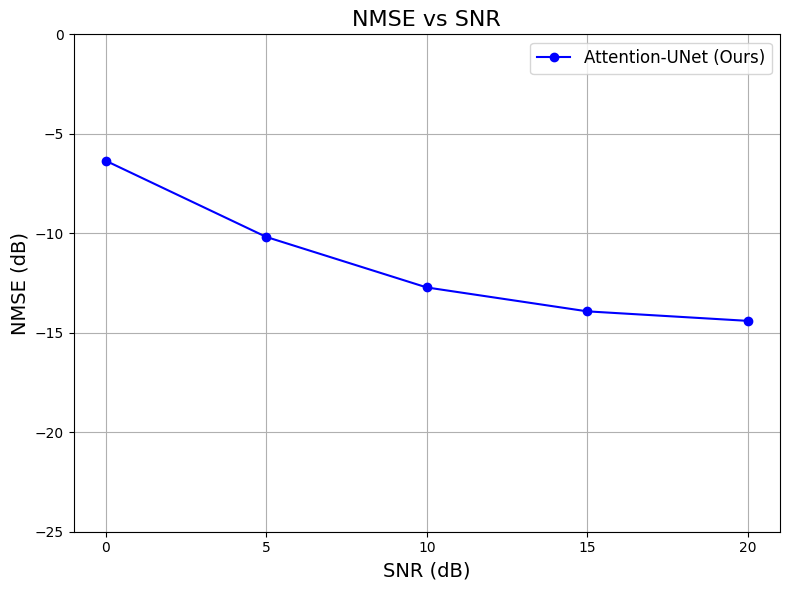

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# ====== Utility: Add Noise ======
def add_noise(y_clean, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(y_clean)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

# ====== Utility: Preprocess for Attention-UNet (Real, Imag, Amp, Phase) ======
def preprocess_input(y):
    y_real = np.real(y)
    y_imag = np.imag(y)
    y_amp = np.abs(y)
    y_phase = np.angle(y)
    return np.stack([y_real, y_imag, y_amp, y_phase], axis=1)

# ====== Testing over SNRs Safely (Batching) ======
def evaluate_model_over_snr(model, y_clean, y_target, test_indices, snr_list, batch_size=64):
    nmse_list_db = []

    model.eval()

    for snr in snr_list:
        print(f"\n=== Testing at SNR = {snr} dB ===")

        # Prepare noisy test samples
        y_test_clean = y_clean[test_indices]  # select only test samples
        y_test_noisy = add_noise(y_test_clean, snr)
        X_test_noisy = preprocess_input(y_test_noisy)

        # Convert to tensors
        X_test_tensor = torch.tensor(X_test_noisy, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_target[test_indices], dtype=torch.float32)

        # DataLoader for test batching
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Evaluate NMSE
        nmse_total = 0.0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred = model(X_batch)

                mse = torch.mean(torch.abs(y_pred - y_batch) ** 2, dim=[1,2])
                power = torch.mean(torch.abs(y_batch) ** 2, dim=[1,2])
                nmse_batch = mse / power
                nmse_total += torch.sum(nmse_batch).item()

        nmse = nmse_total / len(test_loader.dataset)
        nmse_db = 10 * np.log10(nmse)

        nmse_list_db.append(nmse_db)

        print(f"SNR {snr} dB: NMSE = {nmse:.6f} | {nmse_db:.2f} dB")

    return nmse_list_db

# ====== Plotting NMSE vs SNR ======
def plot_nmse_vs_snr(snr_list, nmse_list_db):
    plt.figure(figsize=(8,6))
    plt.plot(snr_list, nmse_list_db, marker='o', linestyle='-', color='b', label='Attention-UNet (Ours)')
    plt.grid(True)
    plt.xlabel('SNR (dB)', fontsize=14)
    plt.ylabel('NMSE (dB)', fontsize=14)
    plt.title('NMSE vs SNR', fontsize=16)
    plt.xticks(snr_list)
    plt.ylim([-25, 0])
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Load best model
model.load_state_dict(torch.load('best_attention_unet.pth'))

# List of SNRs to test
snr_list = [0, 5, 10, 15, 20]

# Get test indices
test_indices = test_dataset.indices  # VERY IMPORTANT

# Now run evaluation
nmse_list_db = evaluate_model_over_snr(
    model=model,
    y_clean=y_clean,
    y_target=y_target,
    test_indices=test_indices,
    snr_list=snr_list,
    batch_size=64
)

# Finally plot
plot_nmse_vs_snr(snr_list, nmse_list_db)


# Saleh-Valenzuela for ULA


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# === PARAMETERS ===
N_samples = 100000
N = 256  # Number of antennas for ULA
M = 128  # Measurements
L = 3    # Paths
p = 4    # Number of 1's per column in switch matrix
snr_db = np.arange(0, 21, 5)

np.random.seed(0)
torch.manual_seed(0)

# === 1D-DFT Matrix U for ULA ===
U = np.fft.fft(np.eye(N), norm='ortho')

# === Saleh-Valenzuela Channel Model for ULA ===
def SV_ULA_spatial(N, L):
    h = np.zeros(N, dtype=complex)
    n = np.arange(N)
    for _ in range(L):
        α = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
        θ = np.random.uniform(-np.pi/2, np.pi/2)
        a = np.exp(-1j * np.pi * n * np.sin(θ)) / np.sqrt(N)
        h += α * a
    return np.sqrt(N / L) * h

# === Switch-based Selection Matrix (binary 0/1) ===
def create_switch_matrix(M, N, p):
    A = np.zeros((M, N))
    for j in range(N):
        indices = np.random.choice(M, p, replace=False)
        A[indices, j] = 1
    return A

# Create fixed switch matrix
A_switch = create_switch_matrix(M, N, p)

# === Generate channels ===
h_spatial = np.zeros((N_samples, N), dtype=complex)
for i in range(N_samples):
    h_spatial[i] = SV_ULA_spatial(N, L)

# === Get CLEAN BEAMSPACE CHANNEL ===
h_beamspace = (U @ h_spatial.T).T  # N_samples x N

# === NORMALIZE CHANNELS ===
norm_factor = np.sqrt(np.mean(np.abs(h_beamspace)**2))
h_beamspace_normalized = h_beamspace / norm_factor

# === Get MEASUREMENTS ===
y_clean = (A_switch @ h_beamspace_normalized.T).T  # N_samples x M

# === Split real/imag/amplitude/phase ===
def preprocess_input(y):
    y_real = np.real(y)
    y_imag = np.imag(y)
    y_amp = np.abs(y)
    y_phase = np.angle(y)
    return np.stack([y_real, y_imag, y_amp, y_phase], axis=1)  # (batch, 4, M)

# === Inputs and Targets ===
X = preprocess_input(y_clean)
y_target = np.stack([np.real(h_beamspace_normalized), np.imag(h_beamspace_normalized)], axis=1)

# === Tensor Datasets ===
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)

# Sizes
n_total = len(X_tensor)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

# Random split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    TensorDataset(X_tensor, y_tensor),
    [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(42)  # reproducibility
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv1d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, channels)
        self.norm2 = nn.GroupNorm(8, channels)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = self.norm1(x)
        out = F.silu(out)
        out = self.conv1(out)
        out = self.dropout(out)
        out = self.norm2(out)
        out = F.silu(out)
        out = self.conv2(out)
        return x + out

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.scale = (channels // 8) ** 0.5

    def forward(self, x):
        B, C, L = x.shape
        qkv = self.qkv(x)
        q, k, v = torch.chunk(qkv, 3, dim=1)
        attn = torch.softmax(torch.bmm(q.transpose(1, 2), k) / self.scale, dim=-1)
        out = torch.bmm(attn, v.transpose(1, 2)).transpose(1, 2)
        return x + out

class Downsample(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Conv1d(in_c, out_c, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.ConvTranspose1d(in_c, out_c, 4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class AttentionUNet(nn.Module):
    def __init__(self, M, N):
        super().__init__()
        self.fc = nn.Linear(M * 4, N)

        self.enc1 = nn.Sequential(
            Downsample(1, 32),
            ResidualBlock(32),
            AttentionBlock(32)
        )
        self.enc2 = nn.Sequential(
            Downsample(32, 64),
            ResidualBlock(64),
            AttentionBlock(64)
        )
        self.enc3 = nn.Sequential(
            Downsample(64, 128),
            ResidualBlock(128),
            AttentionBlock(128)
        )

        self.dec1 = nn.Sequential(
            Upsample(128, 64),
            ResidualBlock(64),
            AttentionBlock(64)
        )
        self.dec2 = nn.Sequential(
            Upsample(128, 32),
            ResidualBlock(32),
            AttentionBlock(32)
        )
        self.dec3 = nn.Sequential(
            Upsample(64, 16),
            ResidualBlock(16),
            AttentionBlock(16)
        )

        self.out = nn.Conv1d(16, 2, 1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.fc(x)  # (batch, N)
        x = x.unsqueeze(1)  # (batch, 1, N)

        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)

        d1 = self.dec1(e3)
        d1 = torch.cat((d1, e2), dim=1)

        d2 = self.dec2(d1)
        d2 = torch.cat((d2, e1), dim=1)

        d3 = self.dec3(d2)

        out = self.out(d3)
        return out


In [4]:
# === LOSS, OPTIMIZER, and SCHEDULER ===
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(M=M, N=N).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# === TRAIN FUNCTION ===
def train(model, train_loader, val_loader, n_epochs=100):
    best_val_loss = np.inf
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        scheduler.step()

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f'Epoch [{epoch+1}/{n_epochs}] | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_attention_unet.pth')

    print('Training Complete.')
    return history

# === TEST FUNCTION ===
def test(model, test_loader):
    model.eval()
    nmse_total = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)

            mse = torch.mean((y_pred - y_batch) ** 2, dim=[1,2])
            power = torch.mean(y_batch ** 2, dim=[1,2])
            nmse_batch = mse / power
            nmse_total += torch.sum(nmse_batch).item()

    avg_nmse = nmse_total / len(test_loader.dataset)
    avg_nmse_db = 10 * np.log10(avg_nmse)
    return avg_nmse, avg_nmse_db


In [ ]:
# === FUNCTION TO ADD NOISE ===
def add_noise(y_clean, snr_db):
    snr_linear = 10**(snr_db / 10)
    signal_power = np.mean(np.abs(y_clean)**2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power/2) * (np.random.randn(*y_clean.shape) + 1j*np.random.randn(*y_clean.shape))
    return y_clean + noise

snr_train_list = [0, 5, 10, 15, 20]  # SNRs to train separately
nmse_db_unet = []

for snr in snr_train_list:
    print(f"\n=== Training and Testing at SNR = {snr} dB ===")

    # === Generate noisy training measurements at fixed SNR ===
    y_noisy_train = add_noise(y_clean, snr)  # add noise once to all samples
    X_train = preprocess_input(y_noisy_train)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor_target = torch.tensor(y_target, dtype=torch.float32)

    # === Prepare datasets ===
    dataset = TensorDataset(X_tensor, y_tensor_target)

    n_total = len(dataset)
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(42)
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # === Initialize new model ===
    model = AttentionUNet(M=M, N=N).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # === Train model ===
    train(model, train_loader, val_loader, n_epochs=50)

    # === Save the trained model (optional) ===
    model_path = f'best_attention_unet_snr{snr}.pth'
    torch.save(model.state_dict(), model_path)

    # === Load best model for testing (optional reload) ===
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # === Testing ===
    y_test_clean = y_clean[test_dataset.indices]  # Pick clean test samples
    y_test_noisy = add_noise(y_test_clean, snr)   # Add *same SNR* noise for testing
    X_test_noisy = preprocess_input(y_test_noisy)

    X_test_tensor = torch.tensor(X_test_noisy, dtype=torch.float32).to(device)
    y_test_tensor = y_tensor[test_dataset.indices].to(device)

    with torch.no_grad():
        y_pred = model(X_test_tensor)

        mse = torch.mean((y_pred - y_test_tensor) ** 2, dim=[1,2])
        power = torch.mean((y_test_tensor) ** 2, dim=[1,2])
        nmse_batch = mse / power
        nmse = torch.mean(nmse_batch).item()

    nmse_db_value = 10 * np.log10(nmse)
    nmse_db_unet.append(nmse_db_value)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# === 1) PARAMETERS ===
N_samples = 100000
N = 256               # ULA: 256 antennas
M = 128
L = 3                 # number of SV paths
S = 24                # OMP sparsity
snr_db = np.arange(0, 21, 5)

np.random.seed(0)

# === 2) PHASE-SHIFTER SENSING MATRIX A ∈ {±1/√M} ===
A = np.random.choice([1, -1], size=(M, N)) / np.sqrt(M)

# === 3) 1-D UNITARY DFT MATRIX U (for ULA) ===
U = np.fft.fft(np.eye(N), norm='ortho')

# === 4) SALEH-VALENZUELA ULA CHANNEL GENERATOR ===
def SV_ULA_spatial(N, L):
    h = np.zeros(N, dtype=complex)
    n = np.arange(N)
    for _ in range(L):
        α = (np.random.randn() + 1j*np.random.randn()) / np.sqrt(2)
        θ = np.random.uniform(-np.pi/2, np.pi/2)
        a = np.exp(-1j * np.pi * n * np.sin(θ)) / np.sqrt(N)
        h += α * a
    return np.sqrt(N / L) * h

# === 5) BUILD SPATIAL CHANNELS (NOT BEAMSPACE YET!) ===
h_spatial = np.zeros((N_samples, N), dtype=complex)
for i in range(N_samples):
    h_spatial[i] = SV_ULA_spatial(N, L)

# === 6) CLEAN MEASUREMENTS ===
y_clean = (A @ (U @ h_spatial.T)).T  # y = A * (U * h_spatial)

# === 7) OMP FUNCTION ===
def omp(y, A, S):
    residual = y.copy()
    support = []
    x_hat = np.zeros(A.shape[1], dtype=complex)
    for _ in range(S):
        corr = A.conj().T @ residual
        idx = np.argmax(np.abs(corr))
        if idx in support:
            break
        support.append(idx)
        A_sub = A[:, support]
        x_sub, *_ = np.linalg.lstsq(A_sub, y, rcond=None)
        residual = y - A_sub @ x_sub
    x_hat[support] = x_sub
    return x_hat

# === 8) SWEEP SNR AND COMPUTE NMSE ===
nmse_db = []
for db in snr_db:
    snr_lin = 10**(db/10)
    σ = np.sqrt(1/(2*snr_lin))
    errors = []
    for i in range(N_samples):
        noise = (np.random.randn(M) + 1j*np.random.randn(M)) * σ
        y_noisy = y_clean[i] + noise
        h_est_spatial = np.linalg.pinv(U) @ omp(y_noisy, A, S)  # recover h_spatial
        h_est_beam = U @ h_est_spatial  # transform to beamspace
        h_true_beam = U @ h_spatial[i]  # true beamspace
        errors.append(np.linalg.norm(h_est_beam - h_true_beam)**2
                      / np.linalg.norm(h_true_beam)**2)
    nmse_db.append(10*np.log10(np.mean(errors)))



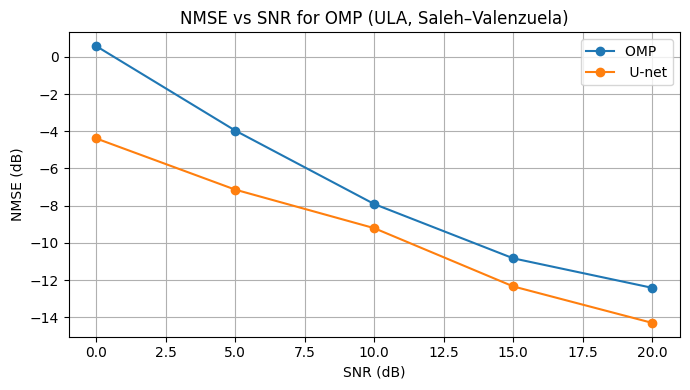

In [11]:
plt.figure(figsize=(7,4))
plt.plot(snr_db, nmse_db , 'o-', label=f'OMP ')
plt.plot(snr_db, nmse_db_unet , 'o-', label=f' U-net')
plt.xlabel("SNR (dB)")
plt.ylabel("NMSE (dB)")
plt.title("NMSE vs SNR for OMP (ULA, Saleh–Valenzuela)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
